## Distinguer des chats et des chiens avec un réseau de neurones à convolution

Avec un classifieur linéaire, nous avions pu distinguer des photos de chiens de photos de chats avec une précision de moins de 60%. 

Nous allons maintenant créer et entraîner un réseau de neurones à convolution pour améliorer ce classifieur.

Les images que nous allons utiliser sont les mêmes que celles utilisées pour entraîner le classifieur linéaire. 

Elles sont issues d'une [compétition de la plateforme Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview). Cette compétition, datant de 2013, a été remportée par un français, Pierre Sermanet (qui travaille maintenant pour Google Brain), qui a obtenu une précision de 98.9% en utilisant un réseau de neurones convolutionnel. Cependant, comme nous n'allons considérer ici qu'un petit sous-ensemble de ces données, nous n'aurons probablement qu'une précision beaucoup plus faible. 

La structure du réseau de neurones que nous allons utiliser est la suivante : 

Le réseau prend en entrée des images de taille 128x128x1. 

Il se compose d’une première couche de convolution, contenant 64 filtres de taille 5x5x1. L’application de cette couche, suivie par celle d’une fonction d’activation, donne en sortie une image de taille 128x128x64. 

Cette couche est suivie par une couche de normalisation par lot, qui permet de normaliser la moyenne et l'écart-type des images en sortie de couche.

Ensuite, une agrégation par maximum permet de diviser par deux la taille des images. Comme nous l’avons vu, leur profondeur n’est pas affectée par l’agrégation, la taille des images en sortie de cette couche est donc 64x64x64. 

La seconde couche de convolution comporte 128 filtres de taille 5x5x64. Elle est suivie par l’application de la fonction d’activation, et les images en sortie ont une dimension de 64x64x128. Elle est encore suivie par une couche de normalisation par lot, puis une nouvelle couche d’agrégation permet de réduire encore la taille des images à 32x32x128. 

Les images sont ensuite aplaties pour former un vecteur, et une couche complètement connectée contenant deux neurones est appliquée. Cette couche donne en sortie un vecteur de deux éléments. La fonction softmax est ensuite appliquée à ce vecteur. La sortie de cette dernière couche représente la probabilité que l’image d’entrée appartienne à chacune des deux classes étudiées. 

![Structure du réseau](Reseaux_de_neurones_a_convolution_structure_reseau.png)


Voici la structure de ce notebook : 
* [Imports](#imports)
* [Création des ensembles de données](#donnees)
    * [Téléchargement de l'ensemble des données](#telechargement)
    * [Pré-traitement des images](#pretraitement)
    * [Construction des données d'entraînement, validation et test](#selection)
* [Réseau de neurones](#reseau)
    * [Création du réseau](#creation_reseau)
    * [Définition des paramètres d'optimisation](#compilation)
    * [Entraînement du réseau](#entrainement)
* [Evaluation du réseau](#evaluation)
* [Sauvegarde et recharge du modèle entraîné](#sauvegarde)
* [Conclusion](#conclusion)
* [A vous de jouer](#avousdejouer)

## Imports <a class="anchor" id="imports"></a>
Nous commençons par importer les paquets nécessaires pour ce notebook. 

La commande ```%matplotlib inline``` permet d'afficher les graphiques de matplotlib avec la bibliothèque graphique intégrée à Notebook. Sans cette commande, les graphiques générés avec ```matplotlib```ne s'afficheront pas. 

Le bibliothèque suivantes sont importées :
- La bibliothèque ```OpenCV```, qui s'importe avec la commande ```import cv2```, nous servira à lire et à prétraiter les images avant qu'elles n'entrent dans le classifieur ;
- ```Matplotlib``` est utilisée pour afficher des images et tracer des courbes ;
- ```Numpy``` sert à faire des calculs matriciels.  Les images lues par ```OpenCV``` sont stockées comme des matrices ```Numpy``` ;
- ```Os``` permet d'utiliser des fonctionnalités dépendantes du système d'exploitation, comme créer des dossiers, ou spécifier des chemins à partir de noms de dossiers ;
- ```Random``` permet de générer des nombres aléatoires. Nous nous en servirons pour initialiser les paramètres du classifieur ;
- ```Shutil``` contient divers outils de gestion des fichiers. Nous nous en servirons pour copier certaines images de la base de données ;
- La bibliothèque ```Scikit-Learn```, qui s'importe avec la commande ```import sklearn```, contient une grande quantité d'outils pour l'apprentissage automatique. Cette librairie nécessite d'importer individuellement tous les sous-paquets qui seront utilisés. Dans ce notebook, nous l'utiliserons pour calculer diverses métriques permettant d'évaluer la performance de notre classifieur, nous importons donc son sous-paquet ```metrics```. Nous l'utiliserons également pour séparer les données en sous-ensembles d'entraînement, validation et test, avec le sous-paquet ```model_selection``` ;
- La bibliothèque ```TensorFlow``` et son module ```Keras``` nous permettront de créer et d'entraîner le réseau de neurones. 

In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import random
from shutil import copyfile
import sklearn.metrics
import sklearn.model_selection
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Ce notebook a été créé avec les versions de paquets suivantes :

In [2]:
print("Version d'OpenCV", cv2.__version__)
print("Version de Numpy", np.__version__)
print("Version de Scikit-Learn", sklearn.__version__)
print("Version de TensorFlow", tf.__version__)
print("Version de Keras", keras.__version__)

Version d'OpenCV 4.8.0
Version de Numpy 1.23.4
Version de Scikit-Learn 1.1.2
Version de TensorFlow 2.6.0
Version de Keras 2.6.0


Certains de ces paquets sont installés par défaut à l'installation de Python. D'autres doivent être installés séparément. 

Si l'import d'un de ces paquets échoue en renvoyant un message d'erreur spécifiant ```ModuleNotFoundError```, c'est probablement que le paquet n'a pas été installé. Dans ce cas, installez le paquet manquant en exécutant la commande ```!pip install <paquet manquant>```.

La cellule qui suit installe tous les paquets nécessaires à ce notebook. Commentez les lignes correspondant aux paquets qui sont déjà installés, exécutez la cellule pour installez les paquets restants, et exécutez à nouveau la cellule effectuant l'import des modules nécessaires. 

In [3]:
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install scikit-learn
!pip install tensorflow
!pip install keras

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable

You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.



Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


## Création d'ensembles de données <a class="anchor" id="donnees"></a>

Bien que nous utilisons le même ensemble de données de base que le notebook correspondant au chapitre 3, la création de l'ensemble de données d'entraînement diffère légèrement. 

Ainsi, il ne sera pas nécessaire d'exécuter certaines cellules de cette partie (qui seront clairement indiquées), comme le téléchargement de l'ensemble de données par exemple, si vous les avez déjà exécutées dans le notebook correspondant au chapitre 3. D'autres, cependant, comme la création des matrices de données d'entraînement, validation et test, devront être obligatoirement exécutées. 

Comme mentionné dans le notebook correpondant au chapitre 3, il existe plusieurs manières d'obtenir cet ensemble de données :
- il peut être téléchargé depuis la [plateforme du concours, Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview). Ceci nécessite de s'inscrire et de créer un compte sur la plateforme ;
- il peut être téléchargé en utilisant la fonction ```load``` du [paquet ```tfds``` de tensorflow](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=en). Les donnnées sont téléchargées au format TFRecord, un format binaire qui permet de stocker des images de manière beaucoup plus compacte et rapidement utilisable que les formats d'images classiques (png, jpeg, etc.), mais qui a l'inconvénient de ne pas permettre une visualisation immédiate du contenu ;
- il peut également être téléchargé depuis le site de [Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765). 

C'est cette dernière solution qui sera utilisée ici. 

Nous allons commencer par télécharger l'ensemble des données, mais nous n'en utiliserons qu'une fraction pour l'entraînement et les tests, afin de limiter les ressources (mémoire et calculs) requises. 

Une fois les données pour l'entraînement et les tests sélectionnées, nous aurons besoin de leur appliquer plusieurs prétraitements avant de les utiliser : nous allons les convertir en niveaux de gris, uniformiser leurs tailles, et normaliser leurs intensités pour qu'elles soient comprises entre 0 et 1. 

### Téléchargement de l'ensemble des données <a class="anchor" id="telechargement"></a>

*Si vous avez déjà téléchargé et décompressé l'ensemble de données dans le notebook précédent, vous pouvez sauter toutes les cellules correspondant à cette partie.*

Nous allons commencer par télécharger l'ensemble des données dans l'archive cats-and-dogs.zip. Nous allons ensuite décompresser l'archive dans le dossier tmp/PetImages, contenant les sous-dossiers 'Cat' et 'Dog'.

Si le lien de téléchargement ne fonctionne pas, vous pouvez exécuter toutes ces étapes manuellement, en commençant par télécharger les images depuis l'adresse https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765.

Pour pouvoir télécharger les données, nous avons besoin d'installer le paquet ```wget```, qui permet de télécharger des fichiers depuis internet. 

Le paquet ```zipfile38``` nous servira à décompresser l'archive.

In [4]:
!pip install wget
!pip install zipfile38

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Nous pouvons maintenant télécharger les images dans l'archive ```cats-and-dogs.zip``` avec ```wget```.

In [5]:
import wget

url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
local_zip_path = "cats-and-dogs.zip"
wget.download(url, local_zip_path)

100% [......................................................................] 824887076 / 824887076

'cats-and-dogs (4).zip'

Ensuite, nous décompressons l'archive grâce au paquet ```zipfile```.

In [6]:
import zipfile

local_zip_path = "cats-and-dogs.zip"
zip_ref = zipfile.ZipFile(local_zip_path, 'r')
zip_ref.extractall()
zip_ref.close()

Le dossier décompressé s'appelle ```PetImages```. 

Si vous l'ouvrez, vous découvrirez qu'il comporte deux sous-dossiers : ```Cat```, qui contient 12 501 images de chats, et ```Dog```, qui contient 12 501 images de chiens. 

### Pré-traitement des images <a class="anchor" id="pretraitement"></a>

Ces images sont en couleurs, avec des intensités entre 0 et 255, et chacune a une taille différente. 

Nous allons tout d'abord les convertir en niveaux de gris, puis nous normaliserons les intensités entre 0 et 1. Enfin, leurs dimensions seront harmonisées. 

Nous allons tout d'abord créer une fonction qui applique toutes ces étapes à une image individuelle. 

Pour cela, nous définissons une fonction, ```grayscale_and_resize_image```, qui prend en entrée le chemin vers une image. Cette image est lue, convertie en niveaux de gris, ses instensités sont normalisées, et elle est redimensionnée. 

La normalisation des intensités se fait en divisant l'intensité de chaque pixel par l'intensité maximale sur l'ensemble de l'image. Avant de faire cette division, il est nécessaire de commencer par les convertir les intensités en nombres réels à virgule flottante (```float```). En effet, ces intensités étant représentées par des entiers, leur division par un entier plus grand qu'eux donnera 0. En les convertissant en ```float```, leur division par l'intensité maximale donnera un autre ```float```, compris entre 0 et 1.

Pour le redimensionnment, nous allons utiliser des images de taille 128 x 128. Pour des raisons d'efficacité des calculs, les tailles choisies en entrée sont souvent des puissances de 2.

Nous allons appliquer un redimensionnement simple, qui modifiera le ratio hauteur/largeur de la plupart des images. Il est possible que ceci affecte légèrement la performance de la classification, mais, comme c'est la manière la plus simple de redimensionner une image, c'est généralement celle qui est appliquée lors des premiers tests.

Libre à vous de faire ensuite des expériences avec des images de tailles plus grandes ou plus petites, ainsi qu'avec des redimensionnements qui permettent de conserver le ratio hauteur/largeur des images. 

In [7]:
root_dir = 'PetImages'
cat_dir = 'Cat'
dog_dir = 'Dog'

In [8]:
img_size = 128

In [9]:
def grayscale_resize_normalize_image(input_image_path, output_image_size):
    # On lit l'image
    image_content = cv2.imread(input_image_path)
    # On vérifie que l'image peut être lue.
    if image_content is None:
        print("could not read image ", input_image_path)
        return image_content
    else:
        # On la convertit en niveaux de gris
        grey_image = cv2.cvtColor(image_content, cv2.COLOR_BGR2GRAY)
        # On la redimensionne
        square_image = cv2.resize(grey_image, (output_image_size, output_image_size))
        # On rééchantillonne ses intensités pour qu'elles soient comprises entre 0 et 1 en les divisant par l'intensité max
        normalized_image = square_image.astype(float) / np.max(square_image) 

        return normalized_image

Commençons par appliquer cette fonction à une image pour voir exactement ce qu'elle fait. 

Nous choisissons une image au hasard du dossier ```Cat```, affichons sa taille et ses intensités min et max. 


In [10]:
# Sélection d'une image dans le dosser Cat
train_cat_dir = os.path.join(root_dir, cat_dir)
img_name = os.listdir(train_cat_dir)[0]
img_path = os.path.join(train_cat_dir, img_name)
original_img = cv2.imread(img_path)
print("Taille de l'image originale :", original_img.shape)
print("Intensités min et max de l'image originale :", np.min(original_img), np.max(original_img))

Taille de l'image originale : (375, 500, 3)
Intensités min et max de l'image originale : 0 255


Nous appliquons ensuite la fonction ```grayscale_resize_normalize_image``` à cette image, et affichons sa taille et ses intensités min et max pour vérifier que le prétraitement fonctionne bien. 

In [11]:
# Conversion de l'image grâce à notre fonction grayscale_and_resize_image
processed_img = grayscale_resize_normalize_image(img_path, img_size)
print("Taille de l'image prétraitée :", processed_img.shape)
print("Intensités min et max de l'image prétraitée :", np.min(processed_img), np.max(processed_img))

Taille de l'image prétraitée : (128, 128)
Intensités min et max de l'image prétraitée : 0.004219409282700422 1.0


Affichons maintenant ces deux images. 

Notons que ```OpenCV``` lisant les images en utilisant les canaux de couleur dans l'ordre (B, G, R), il est nécessaire de remettre les canaux dans l'ordre habituel (R, G, B) avant de les afficher avec ```matplotlib```.

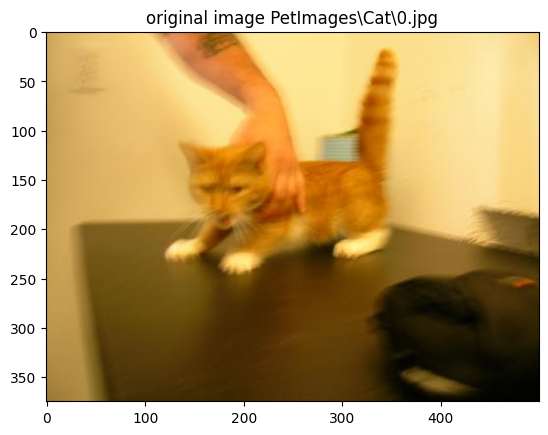

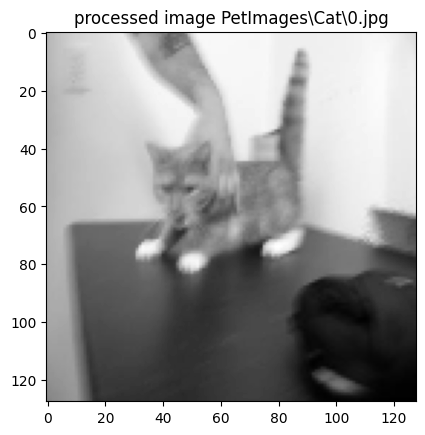

In [12]:
# Affichage de l'image originale
rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB) # Changement d'ordre des canaux de couleur
# Affichage avec matplotlib
plt.imshow(rgb_img)
plt.title("original image " + img_path)
plt.show()

# Affichage de l'image convertie
plt.imshow(processed_img, cmap="gray") # L'argument cmap="gray" permet d'afficher l'image en niveaux de gris
plt.title("processed image " + img_path)
plt.show()

### Construction des données d'entraînement, validation et test <a class="anchor" id="selection"></a>

Dans le notebook précédent, nous avions créé des dossiers contenant les images d'entraînement et de test. 

Ici, nous allons directement créer les matrices d'images et d'étiquettes qui seront utilisées par le modèle. Ceci nous permettra d'utiliser la fonction ```train_test_split``` de la librairie ```sklearn```. 

La première étape est de construire des matrices X et y contenant toutes les images prétraitées et les étiquettes. Nous utiliserons ensuite la fonction ```train_test_split``` pour les séparer en images à utiliser pour l'entraînement, la validation et les tests. 

La **matrice X** contient toutes les images. Elle est de dimension nombre d'images * hauteur * largeur * nombre de canaux. 

La **matrice y** contient les caractéristiques de chaque image. Nous allons représenter chaque caractéristique par un vecteur de taille 2 : (1, 0) pour les chats, et (0, 1) pour les chiens. Cette représentation, nommée "encodage à chaud" ("one hot encoding" en anglais), est fréquemment utilisée en apprentissage automatique. Cette matrice est de dimensions nombre d'images * nombre de classes.

In [13]:
nb_images_per_pet = 330
source_dir = 'PetImages'

# On initialise la liste X_list, qui contiendra chaque image sous forme d'un vecteur unidimensionnel,
# et la liste y, qui contiendra chaque étiquette sous forme d'un entier égal à 0 ou 1
X_list = []
y_list = []

# On considère chacun des animaux successivement
for class_id, pet_dir in enumerate([cat_dir, dog_dir]):
    print("Traitement des images du dossier", pet_dir)
    print("Ces images ont l'étiquette", [class_id, 1-class_id])
    
    # Création d'une liste contenant les noms de toutes les images de cet animal
    all_pet_filenames = os.listdir(os.path.join(source_dir, pet_dir))
    
    # On mélange la liste avant d'en extraire une portion. La fonction shuffle mélange la liste originale.
    random.shuffle(all_pet_filenames)
    
    # On extrait les nb_images_per_pet premières images de la liste
    subset = all_pet_filenames[:nb_images_per_pet]
    for file_name in subset:
        img_path = os.path.join(source_dir, pet_dir, file_name)
        preprocessed_img = grayscale_resize_normalize_image(img_path, img_size)
        if preprocessed_img is not None:
            # On ajoute une troisième dimension à l'image parce que Keras attend des images avec une profondeur
            X = np.expand_dims(preprocessed_img, -1)
            # On l'ajoute à la liste
            X_list.append(X)
            y_list.append(class_id)
            
# On mélange les deux listes de la même manière
xy = list(zip(X_list, y_list))
random.shuffle(xy)
X_tuple, y_tuple = zip(*xy)

# On convertit X_tuple depuis un tuple de vecteurs en une matrice numpy
X = np.stack(X_tuple, axis=0)

# On encode y_tuple avec un encodage à chaud.
y = np.asarray(y_tuple)
y = np.stack([y, 1-y], axis=-1)

Traitement des images du dossier Cat
Ces images ont l'étiquette [0, 1]
Traitement des images du dossier Dog
Ces images ont l'étiquette [1, 0]
could not read image  PetImages\Dog\5604.jpg


In [14]:
# Vérification des dimensions de X et de y
print("X.shape", X.shape)
print("y.shape", y.shape)

X.shape (659, 128, 128, 1)
y.shape (659, 2)


On peut maintenant utiliser la fonction ```train_test_split``` de la librairie ```sklearn```. 

Cette fonction permet de séparer une matrice d'images et la matrice d'étiquettes correspondante en deux ensembles de données, dans une proportion donnée en argument. Les arguments obligatoire de la fonction sont les suivants :
- matrice contenant les images,
- matrice ou vecteur contenant les étiquettes.

Il est également possible de spécifier plusieurs arguments optionnels :
- ```test_size``` : proportion de données à utiliser dans le second ensemble de données,
-  ```shuffle``` : ce booléen détermine s'il faut, ou non, mélanger les données avant de les séparer en deux groupes. Par défaut, il est mis à ```True```,
- ```random_state``` : ce paramètre permet d'initialiser le générateur de nombre aléatoires d'une manière reproductible, ce qui permet d'obtenir le même résultat lorsqu'on exécute plusieurs fois la fonction,
- ```stratify``` : si cet argument vaut ```None``` (ce qui est la valeur par défaut), alors les données sont séparées de manière aléatoire. Si on donne la liste des étiquettes comme valeur à cet argument, les données seront séparées de manière stratifiées, c'est à dire que chaque ensemble de données contiendra la même proportion d'images de chacune des classes.

La fonction ```train_test_split``` ne permettant de séparer un ensemble de données qu'en deux parties, nous l'exécutons deux fois :
- une première fois pour séparer les images *entraînement + validation* des images de *test*, avec une proportion de 80% pour le premier ensemble et 20% pour le second,
- une deuxième fois pour séparer les images *entraînement + validation* renvoyées par la première exécution en images d'*entraînement* et images de *validation*, avec encore une fois une proportion de 80% pour le premier ensemble et 20% pour le second.

In [15]:
# Séparation des images en train + val et test
X_train_val, X_test, y_train_val, y_test = sklearn.model_selection.train_test_split(X, y, 
                                                                                    test_size=0.2, 
                                                                                    random_state=42,
                                                                                    stratify=y)

In [16]:
# Affichage des dimensions des matrices créées
print("X_train_val.shape", X_train_val.shape)
print("y_train_val.shape", y_train_val.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

X_train_val.shape (527, 128, 128, 1)
y_train_val.shape (527, 2)
X_test.shape (132, 128, 128, 1)
y_test.shape (132, 2)


L'ensemble "entraînement + validation" contient 80% des 660 images de départ, soit 528 images. La matrice X_train_val a donc effectivement pour taille nombre d'images * hauteur * largeur * nombre de canaux, i.e. 421 * 128 * 128 * 1. 

Les étiquettes étant encodées à chaud, la matrice y_train_val a pour taille nombre d'images * nombre de classes, i.e. 421 * 2.

L'ensemble de test contient 20% des 660 images de départ, soit 132 images. La matrice X_test a donc effectivement pour taille nombre d'images * hauteur * largeur * nombre de canaux, i.e. 132 * 128 * 128 * 1. 

Les étiquettes étant encodées à chaud, la matrice y_test a pour taille nombre d'images * nombre de classes, i.e. 132 * 2.

In [17]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_val.shape", X_val.shape)
print("y_val.shape", y_val.shape)

X_train.shape (421, 128, 128, 1)
y_train.shape (421, 2)
X_val.shape (106, 128, 128, 1)
y_val.shape (106, 2)


L'ensemble d'entraînement contient 80% des 528 images de l'ensemble "entraînement + validation", soit 422 images. La matrice X_train a donc effectivement pour taille nombre d'images * hauteur * largeur * nombre de canaux, i.e. 422 * 128 * 128 * 1. La matrice y_train a pour taille nombre d'images * nombre de classes, i.e. 422 * 2.

L'ensemble de validation contient 20% de ces images, soit 105 images. La matrice X_val a donc effectivement pour taille nombre d'images * hauteur * largeur * nombre de canaux, i.e. 105 * 128 * 128 * 1. La matrice y_train a pour taille nombre d'images * nombre de classes, i.e. 105 * 2.

## Réseau de neurones  <a class="anchor" id="reseau"></a>

Dans cette partie, nous allons réaliser les différentes étapes permettant de créer et d'entraîner un réseau de neurones. 

La première étape est de **créer l'architecture du réseau**. C'est à cette étapes que sont définies les différentes couches le composant. 

Ensuite, on définit divers éléments utiles à l'optimisation des poids de ce réseau. On parle de **compilation du modèle**. Ces éléments sont la fonction d'optimisation à utiliser, la fonction coût à minimiser, les métriques à calculer à chaque itération, et les poids éventuels à appliquer à chaque classe lors du calcul de la fonction-coût.

Enfin, le modèle est **entraîné**. C'est dans les arguments de la fonction ```fit```, qui réalise l'entraînement, que les paramètres tels que le nombre d'itérations à effectuer ou la taille de batch sont précisés. 

### Création du réseau <a class="anchor" id="creation_reseau"></a>

Voici la structure du réseau que nous allons construire :

![Structure du réseau](Reseaux_de_neurones_a_convolution_structure_reseau.png)

Nous allons utiliser la bibliothèque ```Keras``` de ```Tensorflow```. La classe ```Sequential``` permet de créer un réseau comme une succession de couches simples. 

Le constructeur de la classe ```Sequential``` prend comme argument une liste de couches.

La **première couche de convolution** utilise la classe ```Conv2D```. Cette classe accepte les arguments suivants :
- Le nombre de filtres, 
- Leur taille, 
- Le type de la fonction d'activation s'il faut en appliquer une. Si ce champ est laissé vide, aucune fonction d'activation n'est appliquée en sortie de la couche de convolution.

Comme cette couche est la première couche du réseau, il faut également lui fournir la taille des images d'entrée. Cette information n'est pas nécessaire pour les couches suivantes.

La **couche de normalisation par lot** ("batch normalization" en anglais) utilise la classe ```BatchNormalization```. 

La **couche d'agrégation par maximum** ("max pooling" en anglais) est construite grâce à la classe ```MaxPool2D```. Cette classe prend comme seul argument la taille de sous-échantillonnage. 

Nous créons ensuite la **seconde couche de convolution**, cette fois sans avoir besoin de préciser la taille des images d'entrée, suivie par une **seconde couche de normalisation par lot** puis une **seconde couche d'agrégation par maximum**.

Enfin, notre image en sortie de la dernière couche d'agrégation est aplatie grâce à la classe ```Flatten```, puis la **couche complètement connectée** est créée avec la classe ```Dense```. Cette couche prend comme arguments :
- Le nombre de neurones dans cette couche,
- Le type de la fonction d'activation s'il faut en appliquer une. 

Enfin, la **fonction softmax** est appliquée à la sortie de la dernière couche, grâce à la classe ```Softmax```. 

En seulement 8 lignes de code, nous avons défini notre modèle. 

*Remarque : Notons que, même si nos images sont des images couleur, et qu'elles sont par conséquent représentées par des matrices à trois dimensions (deux dimensions spatiales, et une dimension de couleur), ```Keras``` les considère comme des images 2D. C'est pourquoi les couches de convolution et d'agrégation utilisent les classes ```Conv2D``` et ```MaxPool2D```. Il existe aussi les classes Conv3D et MaxPool3D, utilisées pour les images ayant trois dimensions spatiales.* 

*Autre remarque : La classe ```Sequential``` ne permet pas de créer des modèles plus complexes, où les différentes couches ont plusieurs images en entrée ou en sortie. Dans ces cas, il faut créer les couches une par une, en utilisant les différentes classes ```Conv2D```, ```MaxPool2D```, ```Flatten```, ```Dense```, etc., et définir manuellement les entrées et les sorties de chacune.*


In [18]:
# Définition du modèle
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(filters=64, 
                                                           kernel_size=5, 
                                                           activation = 'relu', 
                                                           input_shape = (img_size, img_size, 1)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(),
                                    tf.keras.layers. Conv2D(filters=128, 
                                                            kernel_size=5, 
                                                            activation = 'relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(2, activation = 'relu'),
                                    tf.keras.layers.Softmax() ])

La fonction ```summary``` permet d'afficher l'architecture du réseau. Pour chaque couche, on peut ainsi visualiser son type, la taille de l'image obtenue en sortie, et le nombre de paramètres qu'elle contient.  

In [19]:
# Visualisation de l'architecture du réseau
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 58, 58, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 107648)            0

### Définition des paramètres d'optimisation <a class="anchor" id="compilation"></a>

Nous avons créé l'architecture du modèle, reste à indiquer à ```Keras``` comment optimiser ses poids. 

C'est lors de la **compilation** du modèle qu'on va choisir des informations telles que :
- La fonction d'optimisation, 
- La fonction-coût, 
- D'éventuelles métriques additionnelles à enregistrer à chaque époque.

Ici, nous utilisons la fonction Adam pour l'optimisation, avec un taux d'apprentissage de $10^ -4$, et la fonction-coût d'entropie croisée binaire, qui est le choix le plus courant pour réaliser une classification binaire. 
En plus de la fonction-coût, nous demandons au réseau de calculer la précision à chaque époque. 

Il est également possible de définir sa propre fonction-coût à utiliser pour l'optimisation (il faut alors définir également son gradient), ainsi que ses propres métriques. 

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Entraînement du réseau <a class="anchor" id="entrainement"></a>

L'entraînement du modèle se fait en utilisant la fonction ```fit``` de Keras. Les paramètres de cette fonction sont :
- Les images de test,
- Les étiquettes de test,
- Le nombre d'époques pendant lequel réaliser l'entraînement, 
- La taille de lot à utiliser. 

On peut également préciser les données de validation à utiliser. Ainsi, les métriques sont calculées à chaque époque sur les données de validation et de test, ce qui permet de mieux détecter le suraprentissage. 

On peut également définir des *callbacks* : ce sont des fonctions qui s'exécutent à chaque itération. ```Keras``` en propose un grand nombre. Certains permettent d'ajuster le taux d'apprentissage au cours du temps, d'autres d'interrompre le modèle si la fonction-coût n'évolue plus, d'autres encore d'enregistrer des métriques à afficher dans TensorBoard à chaque sous-itération.

La [documentation](https://keras.io/api/callbacks/) présente l'ensemble des fonctions proposées. 

Il est également possible de définir sa propre fonction. 

In [21]:
# Définition de callbacks. 
# On en ajoute un seul, permettant d'enregistrer des métriques à afficher dans TensorBoard, dans le dossier './logs'
my_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [22]:
# Entraînement
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=my_callbacks)

Epoch 1/20
14/14 [==============================] - 16s 321ms/step - loss: 0.7310 - accuracy: 0.5059 - val_loss: 0.6902 - val_accuracy: 0.5377
Epoch 2/20
14/14 [==============================] - 3s 198ms/step - loss: 0.6428 - accuracy: 0.5796 - val_loss: 0.6835 - val_accuracy: 0.5660
Epoch 3/20
14/14 [==============================] - 3s 198ms/step - loss: 0.6201 - accuracy: 0.6105 - val_loss: 0.6957 - val_accuracy: 0.5566
Epoch 4/20
14/14 [==============================] - 3s 196ms/step - loss: 0.6024 - accuracy: 0.6318 - val_loss: 0.7839 - val_accuracy: 0.5566
Epoch 5/20
14/14 [==============================] - 5s 383ms/step - loss: 0.5717 - accuracy: 0.6508 - val_loss: 0.7141 - val_accuracy: 0.5660
Epoch 6/20
14/14 [==============================] - 3s 199ms/step - loss: 0.5367 - accuracy: 0.6580 - val_loss: 0.7026 - val_accuracy: 0.5660
Epoch 7/20
14/14 [==============================] - 3s 198ms/step - loss: 0.5683 - accuracy: 0.6746 - val_loss: 1.0505 - val_accuracy: 0.5566
Epoch

La fonction ```fit``` renvoie en sortie l'historique des métriques évaluées pendant le processus d'optimisation, sous la forme d'un dictionnaire. 

Commençons par afficher les différentes clefs sauvegardées. 

In [23]:
# Liste des données enregistrées dans l'historique d'optimisation
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


On a enregistré les valeurs de la fonction-coût et de la précision des données d'entraînement et de validation. 

On peut tracer ces valeurs en fonction du nombre d'itérations pour mieux visualiser l'entraînement. 

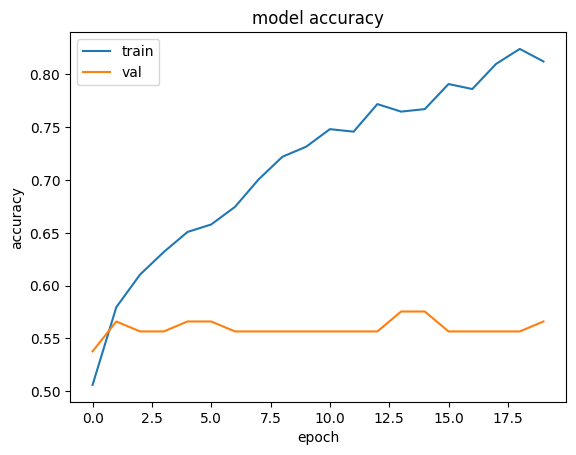

In [24]:
# Affichage de l'accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

La performance est systématiquement moins bonne sur les données de validation que sur les données d'entraînement, ce qui est attendu. 

Cependant, l'ampleur de l'écart nous indique que le réseau est probablement en situation de suraprentissage. 

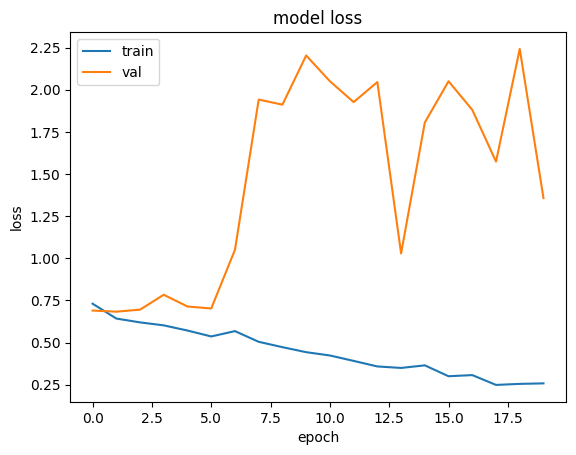

In [25]:
# Affichage de la fonction coût
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Au cours des itérations, la fonction-coût des données d'entraînement décroît, tandis que celle des données de validation croît : il y a donc du surapprentissage.

Pendant l'entraînement ou à l'issue de celui-ci, on peut visualiser ces deux courbes, et d'autres informations, sur l'interface **Tensorboard**. 

Il est possible de consulter Tensorboard directement depuis un notebook, en exécutant la cellule suivante :

In [26]:
%load_ext tensorboard
%tensorboard --logdir logs

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

## Evaluation du classifieur <a class="anchor" id="evaluation"></a>

L'étape d'évaluation est une étape critique du développement d'un modèle d'intelligence artificielle. 

Pour les problèmes de classification binaire, on utilise typiquement trois mesures :
- La **précision** est définie comme le nombre d'images correctement attribuées à la classe i par rapport au nombre total d'images prédites comme appartenant à la classe i. Elle se calcule comme :
\begin{equation}
\textrm{prec} = \frac{\textrm{Nombre de vrais positifs}}{\textrm{Nombre de vrais positifs + Nombre de faux positifs}}
\end{equation}
- La **sensibilité** est définie le nombre d'images correctement attribuées à la classe i par rapport au nombre total d'images appartenant effectivement à la classe i. Elle se calcule comme :
\begin{equation}
\textrm{sens} = \frac{\textrm{Nombre de vrais positifs}}{\textrm{Nombre de vrais positifs + Nombre de faux négatifs}}
\end{equation}
- Le **score F1** est la moyenne harmonique entre précision et sensibilité. Il se calcule comme : 
\begin{equation}
\textrm{F1} = \frac{\textrm{prec}* \textrm{sens}}{\textrm{prec}+\textrm{sens}}
\end{equation}


Nous calculerons également une matrice de confusion pour visualiser les résultats. 

Tous ces calculs utiliseront la base de données de test.

Nous commençons par visualiser plusieurs prédictions faites sur la base de test. 

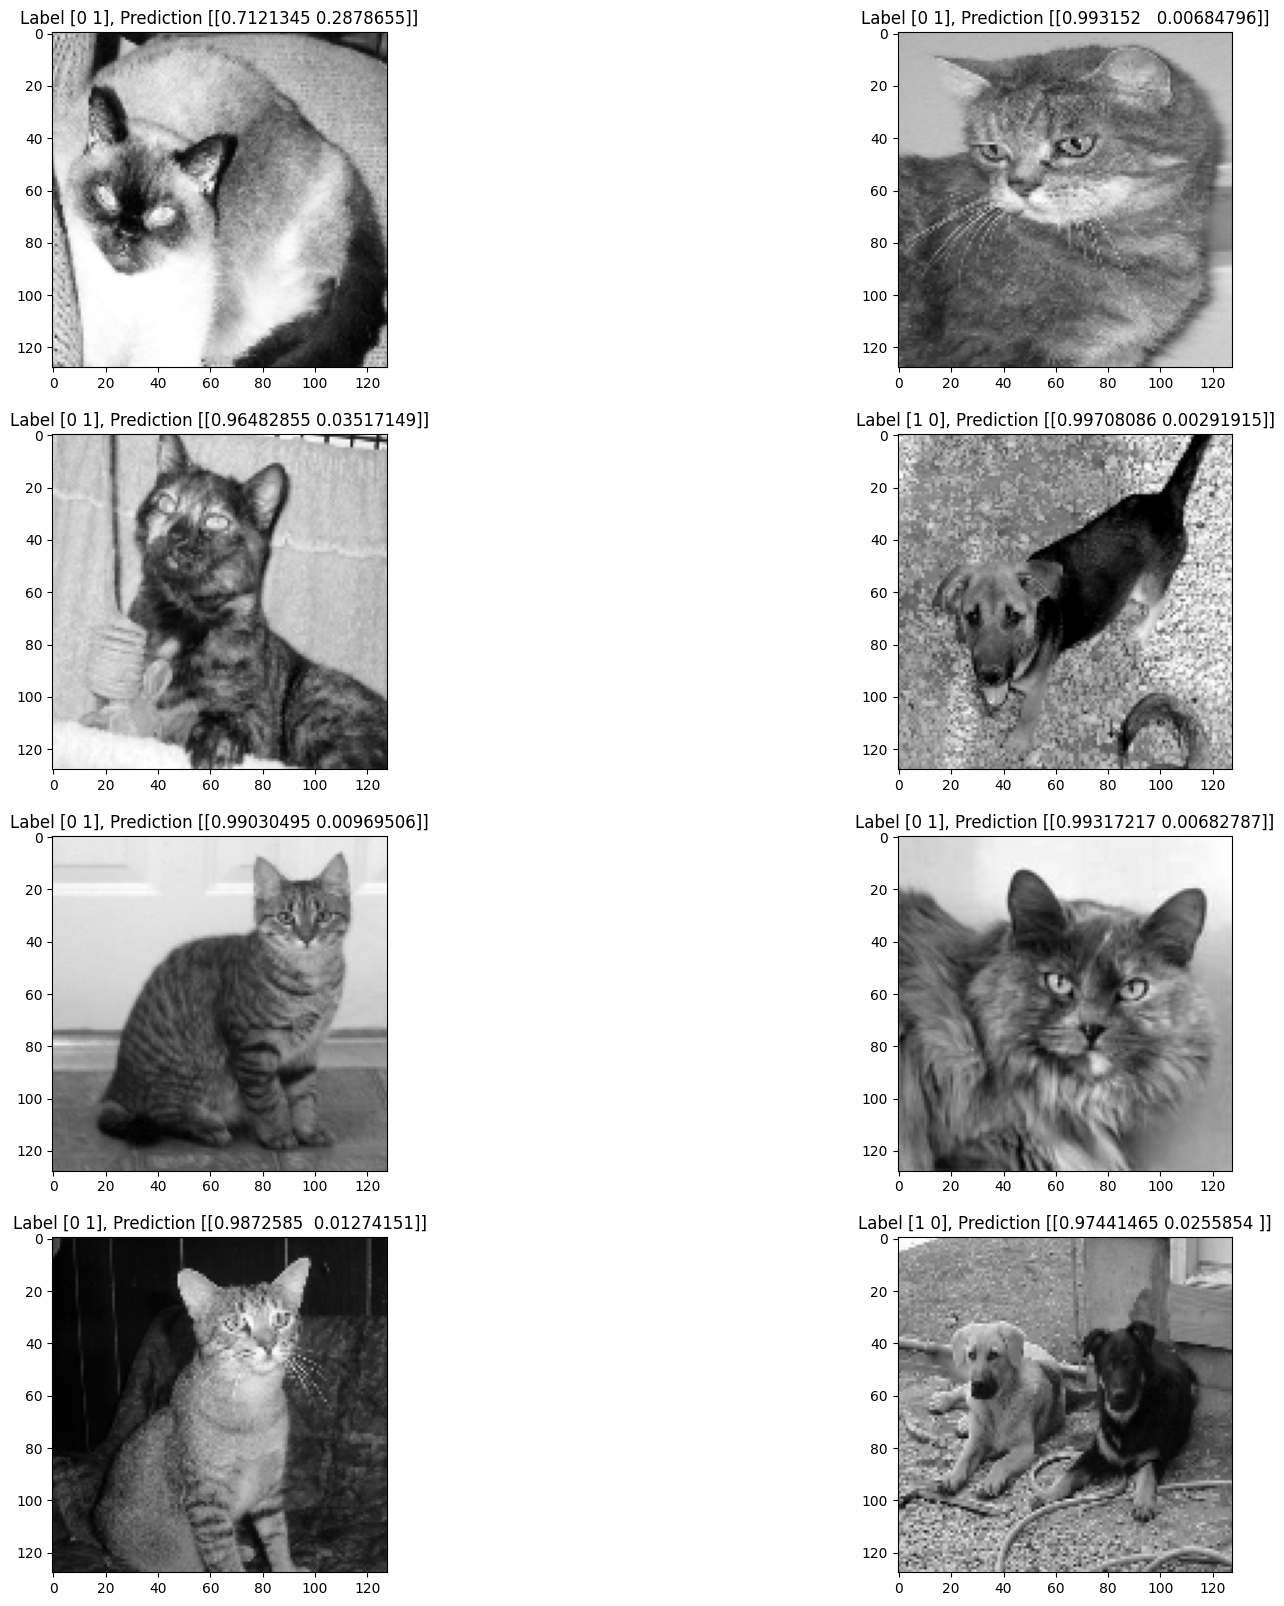

In [27]:
# Création d'un graphique contenant huit sous-figures, organisées en 4 lignes et 2 colonnes, 
# chacune mesurant 20 inches de côté
fig, axes = plt.subplots(4, 2, figsize=(20,20))
# Boucle sur les 8 premières images de notre matrices X_train
for i in range(8):
    # On récupère l'image i
    image = X_test[i,:]
        
    # On prédit sa classe en utilisant la fonction predict
    y_pred = model.predict(np.expand_dims(image, 0))
    
    # On affiche les résultats
    axes.flatten()[i].imshow(image, cmap='gray')
    axes.flatten()[i].set_title('Label ' + str(y_test[i]) +', Prediction ' + str(y_pred))

Nous pouvons maintenant calculer les valeurs de prévision, spécificité et score F1 pour toutes ces images, en utilisant la fonction ```classification_report``` de la bibliothèque ```sklearn```. 

Cette fonction nécessite que les étiquettes soient encodées au format binaire (0 pour les chiens et 1 pour les chats). Nous devons donc convertir les étiquettes prédites et réelles depuis le format à chaud vers ce format. Pour cela, nous utilisons la fonction ```argmax```de ```numpy```, qui appliquée à un vecteur, renvoie l'indice qui contient la valeur maximale. 

Par exemple, considérons un vecteur de prédiction $y = [0.67, 0.33]$, qui correspond à un chien avec l'encodage à chaud.

L'indice contenant la valeur maximale est l'indice 0, ce qui correspond bien à la classe du chien avec l'encodage au format binaire.

In [28]:
# Calcul des prédictions pour les images contenues dans X_train
y_pred = model.predict(X_test)

# Conversion des prédictions et des étiquette réelles au format binaire 
y_pred_bin = np.argmax(y_pred, axis=-1)
y_test_bin = np.argmax(y_test, axis=-1)

# Calcul des métriques en utilisant la bibliothèque sklearn
print(sklearn.metrics.classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.50      0.97      0.66        66
           1       0.50      0.03      0.06        66

    accuracy                           0.50       132
   macro avg       0.50      0.50      0.36       132
weighted avg       0.50      0.50      0.36       132



La bibliothèque ```sklearn``` a aussi une fonction qui permet de tracer la matrice de confusion. 

Il s'agit de la fonction ```ConfusionMatrixDisplay.from_predictions```, qui prend en entrée deux arguments obligatoires :
- une liste d'étiquettes réelles au format binaire ;
- une liste d'étiquettes prédites au format binaire. 

Cette fonction accepte également plusieurs arguments facultatifs. Ici, on précise une colormap bleue, qui est différente de celle choisie par défaut, mais conforme à la manière dont sont généralement affichées les matrices de confusion. 

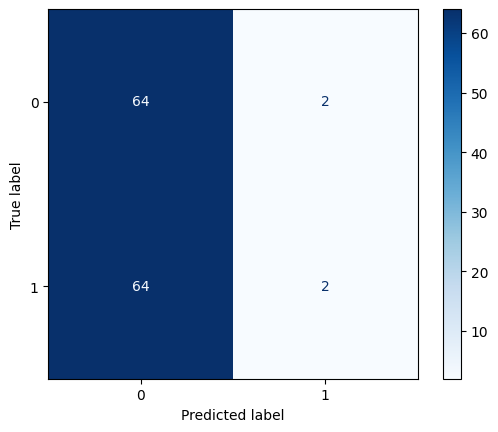

In [29]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test_bin, y_pred_bin, cmap='Blues')

## Sauvegarder et recharger le modèle

On peut maintenant sauvegarder le modèle, et le recharger pour une utilisation ultérieure. 

Il existe plusieurs manières de sauvegarder un modèle dans Tensorflow. Par exemple, il est possible de sauvegarde uniquement les poids, ou l'architecture. 

Nous allons utiliser la fonction ```model.save```, qui sauvegarde tous les éléments d'un modèle (architecture, poids, et configuration d'entraînement). Ainsi, ce modèle peut être réutilisé sans avoir accès au code Python d'origine. 

Cette fonction prend pour seul argument le chemin vers le dossier où effectuer la sauvegarde. 

In [30]:
path_to_model = 'modele_chapitre5'
model.save(path_to_model)

INFO:tensorflow:Assets written to: modele_chapitre5\assets


Recharger le modèle se fait grâce à la fonction ```keras.models.load_model```, qui prend elle aussi comme unique argument le chemin vers le modèle sauvegardé.

In [31]:
reloaded_model = keras.models.load_model(path_to_model)

## Conclusion <a class="anchor" id="conclusion"></a>

Cet exercice nous a permis d'aborder plusieurs sujets :
- La séparation de données en ensembles d'entraînement, validation et test ;
- La création couche par couche d'un réseau de neurones ; 
- L'entraînement d'un modèle ;
- Le calcul et l'affichage de métriques classiques en classification binaire. 

## A vous de jouer ! <a class="anchor" id="avousdejouer"></a>

Pouvez-vous augmenter la précision du réseau ?
Voici quelques pistes :
- Pour limiter le surapprentissage :
    - Utilisez plus d'images ;
    - Modifiez l'architecture du réseau : ajoutez des couches de drop-out, et/ou diminuez le nombre de paramètres entraînables ;
    - Interrompez l'entraînement avant que le surapprentissage ne démarre ;
- Pour améliorer la convergence :
    - Effectuez plus d'itérations ;
    - Modifiez le pas d'apprentissage de la fonction d'optimisation ;
    - Modifiez la taille de batch ;
    - Modifiez la taille des images, ou la manière dont elles sont redimensionnées ;
    - Etc.